# Predicting the stock market 10 days in the future

# Clark Whitehead

# May 3 2022

<img src = "https://editor.analyticsvidhya.com/uploads/17464JywniHv.png" />

<img src = "https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-one-ltr.png?c8a442b3ea9f4cb81f929c089b910c9d" />

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 63 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm

import numpy as np

import pandas as pd

import yfinance as yf

[*********************100%***********************]  1 of 1 completed


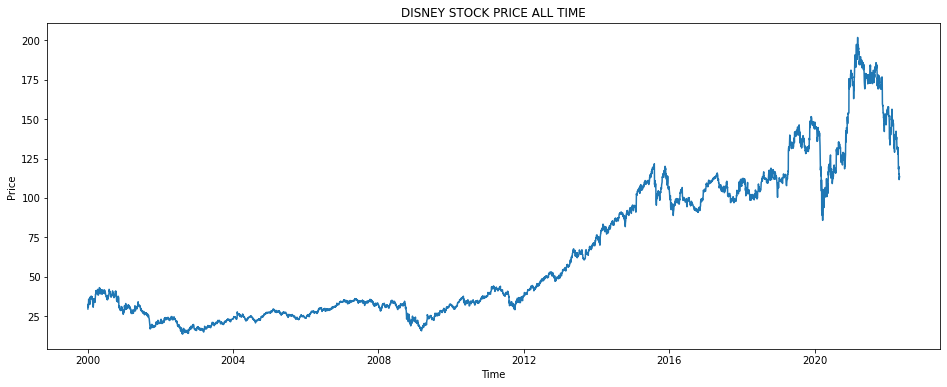

In [3]:
#using CLOSE price only
data = yf.download("DIS", start="2000-01-01", end="2022-05-04")['Close']

plt.figure(figsize=(16, 6))
plt.plot(data)
plt.title('DISNEY STOCK PRICE ALL TIME')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

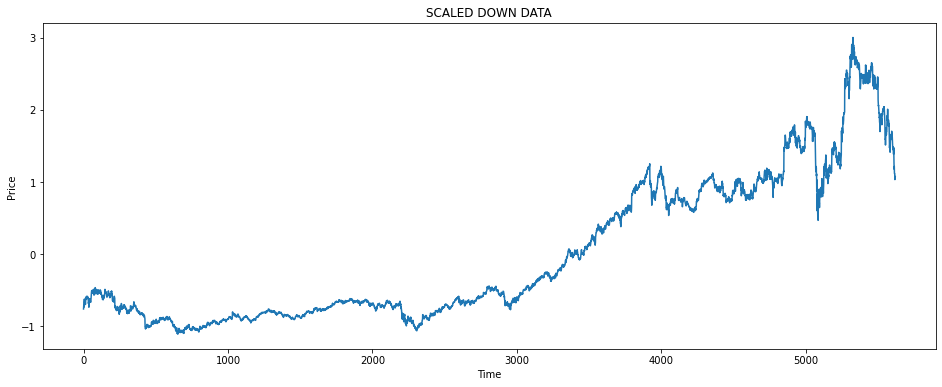

In [4]:
X = data.to_numpy().reshape(-1,1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train = torch.from_numpy(X_scaled).float()

plt.figure(figsize=(16, 6))
plt.plot(X_scaled)
plt.title('SCALED DOWN DATA')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

In [5]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.i2h = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.i2o = nn.Linear(input_dim + hidden_dim, output_dim)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim=1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, hidden_dim)
    
hidden_dim = 128
    
rnn = RNN(1, 128, 1)
optimizer = torch.optim.SGD(rnn.parameters(), lr=.001)
loss_fn = nn.MSELoss()

In [6]:
def train(input_tensor, y_tensor):
    
    hidden = rnn.init_hidden()
    
    for i in range(input_tensor.shape[0]):
        output, hidden = rnn(input_tensor[i].view(1,1), hidden)
        
    loss = loss_fn(output, y_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [7]:
loss_list1 = np.zeros(X_train.shape[0]-100)

for i in tqdm.trange(X_train.shape[0]-100):
    
    input_tensor = X_train[i:i+60]
    y = X_train[i+70].view(1,1)
    
    output, loss = train(input_tensor, y)

    loss_list1[i] = loss
        
        
print("output = {}".format(output))
print("loss = {}".format(loss))

100%|██████████| 5520/5520 [00:59<00:00, 93.45it/s] 

output = tensor([[1.5901]], grad_fn=<AddmmBackward0>)
loss = 0.0009608311229385436


# Loss after 5,000 trainings

Text(0.5, 0, 'Iters')

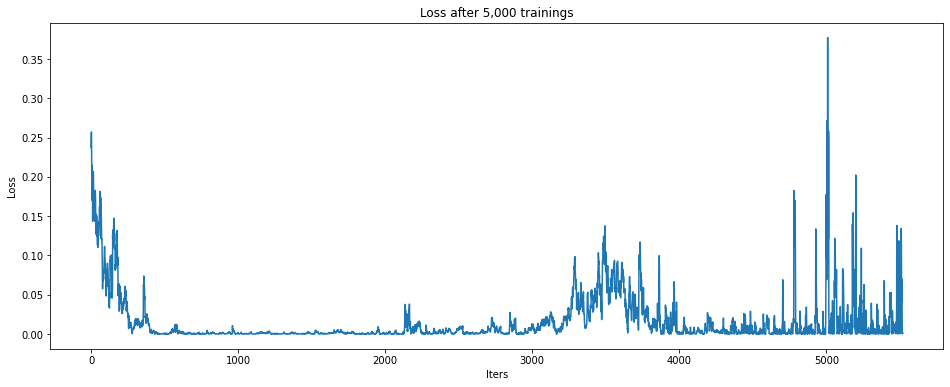

In [8]:
plt.figure(figsize=(16,6))
plt.plot(loss_list1)
plt.title('Loss after 5,000 trainings')
plt.ylabel('Loss')
plt.xlabel('Iters')

In [9]:
def running_mean(x, N):
    #x == an array of data. N == number of samples per average
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
  
val = [-30.45, -2.65, 56.61, 47.13, 47.95, 30.45, 2.65, -28.31, -47.13, -95.89]
print(running_mean(val, 3))

[  7.83666667  33.69666667  50.56333333  41.84333333  27.01666667
   1.59666667 -24.26333333 -57.11      ]


Text(0.5, 0, 'Iters')

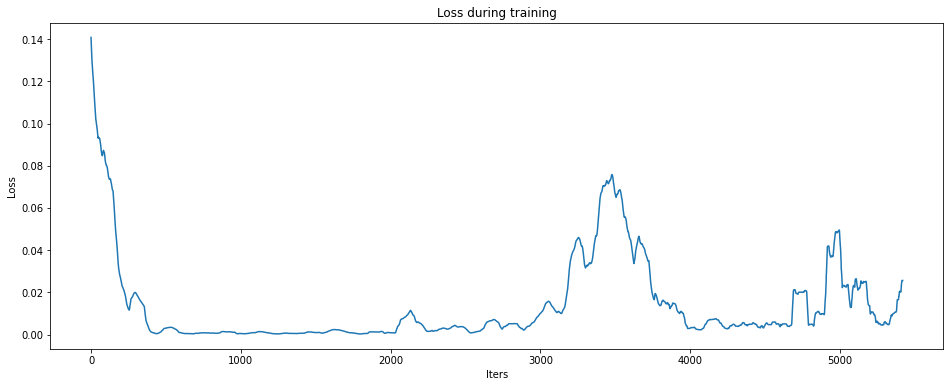

In [10]:
plt.figure(figsize=(16,6))
plt.plot(running_mean(loss_list1, 100))
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Iters')

# Loss after 10,000 trainings

In [11]:
loss_list2 = np.zeros(X_train.shape[0]-100)

for i in tqdm.trange(X_train.shape[0]-100):
    
    input_tensor = X_train[i:i+60]
    y = X_train[i+70].view(1,1)
    
    output, loss = train(input_tensor, y)

    loss_list2[i] = loss
        
        
print("output = {}".format(output))
print("loss = {}".format(loss))

100%|██████████| 5520/5520 [00:35<00:00, 153.88it/s]

output = tensor([[1.5893]], grad_fn=<AddmmBackward0>)
loss = 0.001015735324472189


Text(0.5, 0, 'Iters')

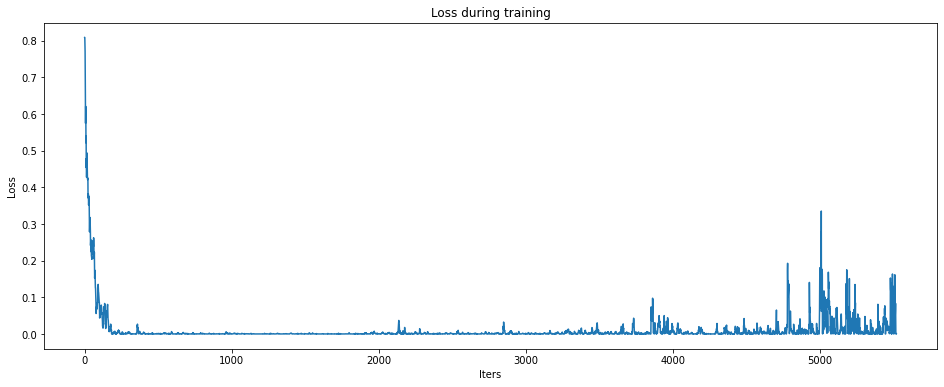

In [12]:
plt.figure(figsize=(16,6))
plt.plot(loss_list2)
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Iters')

Text(0.5, 0, 'Iters')

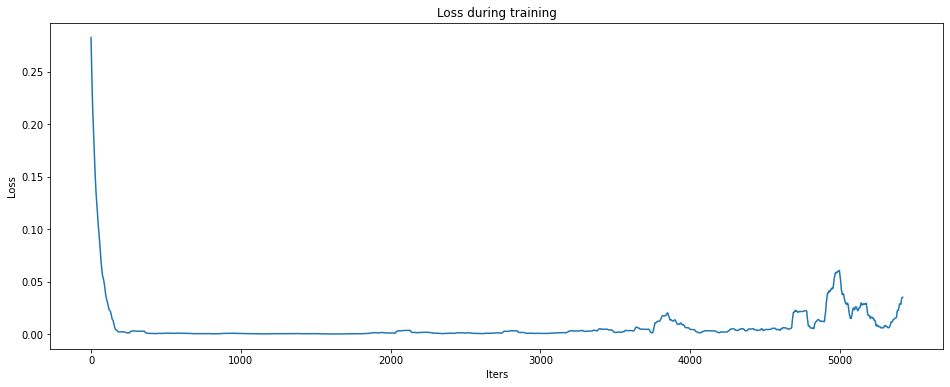

In [13]:
plt.figure(figsize=(16,6))
plt.plot(running_mean(loss_list2, 100))
plt.title('Loss during training')
plt.ylabel('Loss')
plt.xlabel('Iters')

In [15]:
def predict(input_tensor):
    
    with torch.no_grad():
    
        hidden = rnn.init_hidden()

        for i in range(input_tensor.shape[0]):
            output, hidden = rnn(input_tensor[i].view(1,1), hidden)
    
    return output

In [16]:
predict(X_train[4440:4500])

tensor([[0.8750]])

In [17]:
X_train[4510]

tensor([0.9363])

In [18]:
list1 = np.zeros(X_train.shape[0]-100)

for i in tqdm.trange(X_train.shape[0]-100):
    list1[i] = predict(X_train[i:i+60])

100%|██████████| 5520/5520 [00:13<00:00, 397.00it/s]


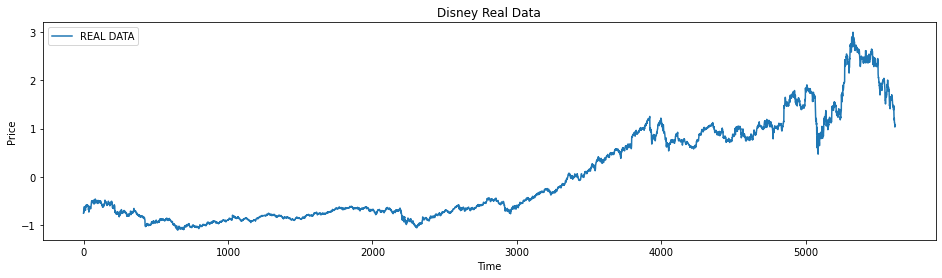

In [19]:
plt.figure(figsize=(16,4))
plt.plot(X_train, label="REAL DATA")

plt.title('Disney Real Data')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show();

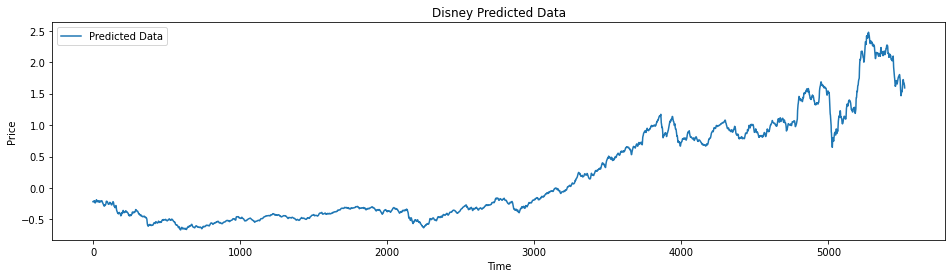

In [20]:
plt.figure(figsize=(16,4))
plt.plot(list1, label="Predicted Data")

plt.title('Disney Predicted Data')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show();

# Apple

[*********************100%***********************]  1 of 1 completed


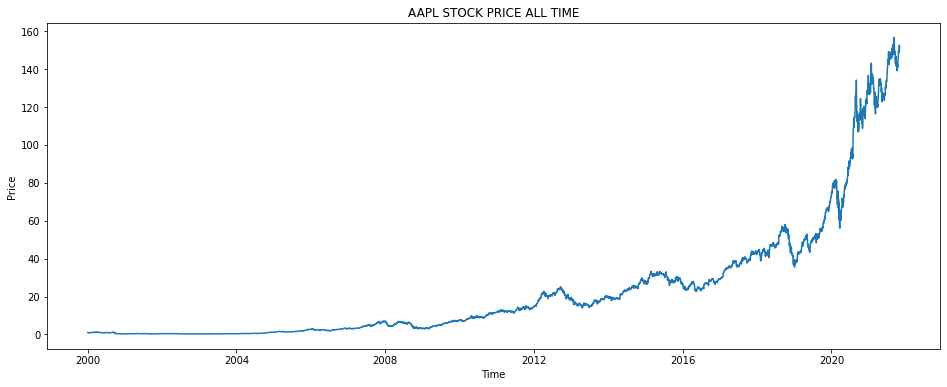

In [21]:
#using CLOSE price only
data = yf.download("AAPL", start="2000-01-01", end="2021-11-01")['Close']

plt.figure(figsize=(16, 6))
plt.plot(data)
plt.title('AAPL STOCK PRICE ALL TIME')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

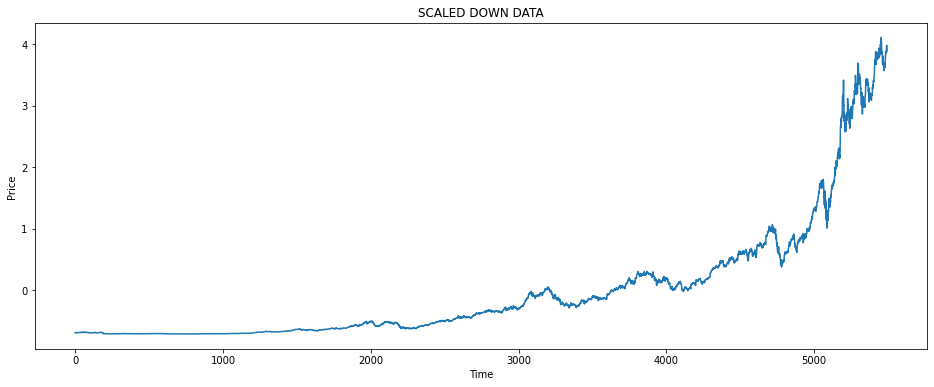

In [22]:
X = data.to_numpy().reshape(-1,1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train = torch.from_numpy(X_scaled).float()

X_scaled
plt.figure(figsize=(16, 6))
plt.plot(X_scaled)
plt.title('SCALED DOWN DATA')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

In [23]:
predict(X_train[2940:3000])

tensor([[-0.0317]])

In [24]:
X_train[3010]

tensor([-0.2940])

In [25]:
list2 = np.zeros(300)

for i in tqdm.trange(300):
    list2[i] = predict(X_train[3000+i:3000+i+60])

100%|██████████| 300/300 [00:00<00:00, 387.06it/s]


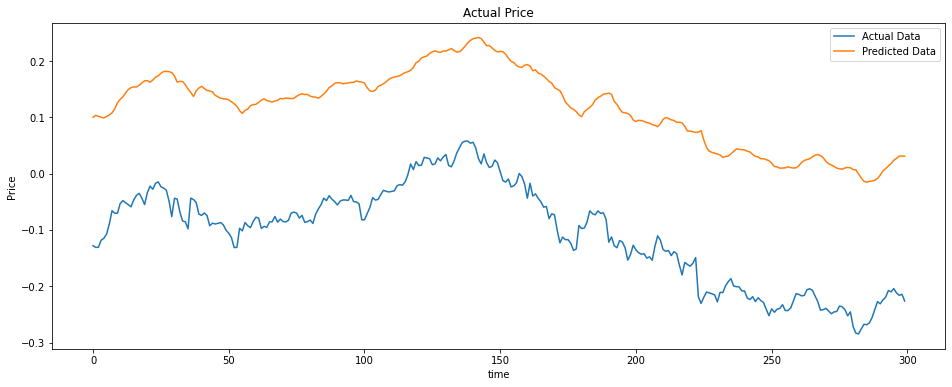

In [26]:
plt.figure(figsize=(16,6))
plt.plot(X_train[3061:3361], label="Actual Data")
plt.plot(list2[:300], label="Predicted Data")
plt.title("Actual Price")
plt.ylabel("Price")
plt.xlabel("time")
plt.legend()
plt.show()

# Predict only 10 days at a time

[*********************100%***********************]  1 of 1 completed


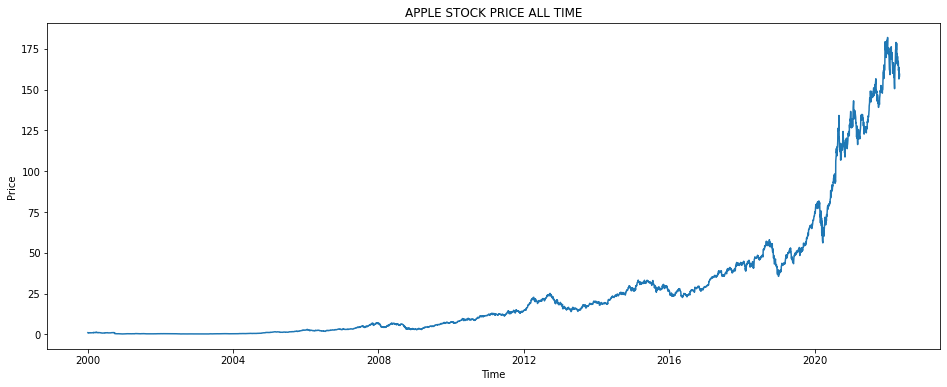

In [106]:
#using CLOSE price only
data = yf.download("AAPL", start="2000-01-01", end="2022-05-04")['Close']
df = torch.from_numpy(data[2000:2200].to_numpy()).float()

plt.figure(figsize=(16, 6))
plt.plot(data)
plt.title('APPLE STOCK PRICE ALL TIME')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show();

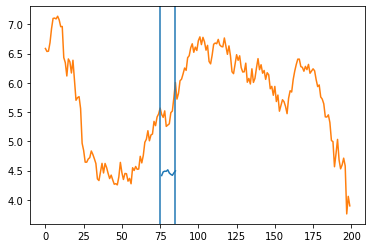

In [107]:
predicted_price_list = np.zeros(10)

x_list = np.zeros(10)

#must be in chunk of 60 since the model was trained to predict the 10th day in the future based on the past 60 days.
start = 15
stop = 75

# line_start = 150
# line_stop = 160
line_start = stop
line_stop = stop+10

for i in range(10):
  predicted_price_list[i] = predict(df[i+start:stop+i])
  x_list[i] = stop + 1 + i

plt.plot(x_list, predicted_price_list)
plt.plot(df)
plt.axvline(x=line_start)
plt.axvline(x=line_stop)